# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from torch.optim import Adam

import torchvision.transforms as transforms
from typing import Text, Dict
import numpy as np
from tqdm import tqdm 
import time
import json
import matplotlib.pyplot as plt

# Dataset

In [2]:
def extract_dataset(batch_size: int):

  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  # Dataset
  training_data = datasets.CIFAR10(root='data',
                                  download=True,
                                  train=True,
                                  transform=transform)

  valid_data = datasets.CIFAR10(root='data',
                              download=True,
                              train=False,
                              transform=transform)

  # Dataloader

  train_dataloader = DataLoader(dataset=training_data,
                                batch_size=batch_size,
                                shuffle=True,
                                drop_last=True)

  valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True)

  dataloader = {'train': train_dataloader,
                'valid': valid_dataloader}

  return dataloader

# Network

In [3]:
class ClassificationNetwork(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, pool_size, n_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pool_1 = nn.MaxPool2d(pool_size, pool_size)
        self.conv_2 = nn.Conv2d(out_channels, out_channels*2, kernel_size)
        self.pool_2 = nn.MaxPool2d(pool_size, pool_size)

        input_size = out_channels*2 * kernel_size * kernel_size
        self.fc1 = nn.Linear(input_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 8)
        self.fc3 = nn.Linear(input_size // 8, n_classes)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        #x = self.fc3(x)

        return x

# Model Class

In [4]:
class Model:

    def __init__(self,
                 name: Text,
                 network: nn.Module,
                 dataloader: Dict[Text, DataLoader],
                 loss_function,
                 seed: int,
                 save_dir: Text,
                 device = None
                 ):

        self.name = name
        self.id = time.time()
        self.network = network.to(device)
        self.dataloader = dataloader
        self.loss_function = loss_function()
        self.optimizer = None

        self.save_dir = save_dir
        self.filepath = None
        self.device = device

        self.epoch_count = []
        self.train_losses, self.valid_losses = [], []

        torch.manual_seed(seed)

    def load_optimizer(self, optimizer: Optimizer, lr: float):
        self.optimizer = optimizer(self.network.parameters(), lr=lr)

    def train(self,
              epochs: int
              ):

        for epoch in tqdm(range(epochs), desc=' > Epochs'):
            self.epoch_count.append(epoch)
            
            # Training Step
            train_loss, valid_loss = self.training_step()
            
            # Plot Losses
            plot_loss(self.train_losses, self.valid_losses)

        return

    def training_step(self):
        train_loss = self.train_one_epoch()
        valid_loss = self.validate_one_epoch()

        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)

        return train_loss, valid_loss

    def train_one_epoch(self):
      self.network.train()

      losses = []

      for images, labels in self.dataloader['train']:

          images = images.to(self.device)
          labels = labels.to(self.device)

          output = self.network(images)
          loss = self.loss_function(output, labels)
          losses.append(loss.item())

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

      return np.mean(losses)

    def validate_one_epoch(self):
      self.network.eval()

      losses = []

      with torch.no_grad():
          for images, labels in self.dataloader['valid']:

              images = images.to(self.device)
              labels = labels.to(self.device)

              output = self.network(images)
              loss = self.loss_function(output, labels)
              losses.append(loss.item())

          return np.mean(losses)

    def predict(self, x):
        print(f' > Input image shape: {x.shape}')
        plt.imshow(x)
        plt.show()

        x = torch.Tensor(x)
        x = x.transpose(0,2)
        x = x.transpose(1,2)
        x = x.unsqueeze(0)

        print(f'\n\n > Image shape preprocessed: {x.shape}\n')

        with torch.no_grad():
          print('--- Inference ---\n')
          output = self.network(x)
          output = output.squeeze()
          print(f' > Output shape: {output.shape}')
          print(f' > Output value: {output}\n\n')

        return output

    def save(self):
        details = {'epoch': self.epoch_count[-1],
                   'train_loss': self.train_losses[-1],
                   'valid_loss': self.valid_losses[-1],
                   'losses': {'train': self.train_losses,
                              'valid': self.valid_losses},
                   'network': self.name,
                   'id': self.id,
                   'optimizer': str(self.optimizer),
                   'loss': str(self.loss_function)}

        folder_save = f'{self.save_dir}{self.name}|{self.id}/'

        filename = f'{self.name}|{self.id}.pth'
        model_path = f'{folder_save}{filename}'
        torch.save(self, model_path)

        details_path = f'{folder_save}details.json'
        save_json(details, details_path)
        self.filepath = model_path

    @staticmethod
    def load(model_path):
        return torch.load(model_path)


def plot_loss(train_losses, valid_losses):
  plt.plot(train_losses, c='r', label='Training Loss')
  plt.plot(valid_losses, c='b', label='Validation Loss')

  plt.legend()
  plt.show()



def save_json(json_dict, filepath):
    with open(filepath, 'w') as j:
        json.dump(json_dict, j, indent=4)
        j.close()

# Hyperparameters

In [5]:
# Dataset
N_CLASSES = 10
BATCH_SIZE = 128

# Network
IN_CHANNELS = 3
OUT_CHANNELS = 4
KERNEL_SIZE = 5
POOL_SIZE = 2

# Training
LEARNING_RATE = 0.001
EPOCHS = 50

# Others
seed = 2022
model_name = 'CIFAR10 Classification Model'
save_dir = '.'


# Training Pipeline

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


 > Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


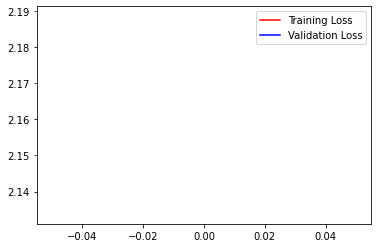

 > Epochs:   2%|▏         | 1/50 [00:22<18:20, 22.47s/it]

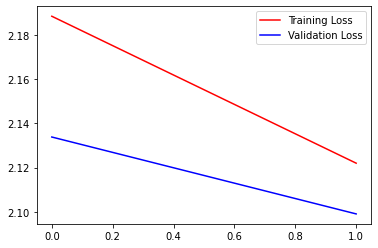

 > Epochs:   4%|▍         | 2/50 [00:44<17:51, 22.33s/it]

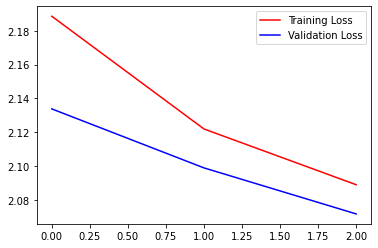

 > Epochs:   6%|▌         | 3/50 [01:06<17:27, 22.28s/it]

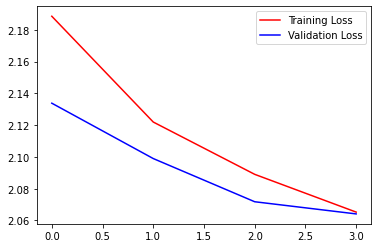

 > Epochs:   8%|▊         | 4/50 [01:30<17:19, 22.60s/it]

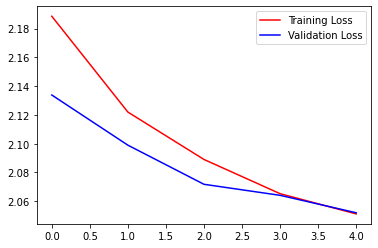

 > Epochs:  10%|█         | 5/50 [01:52<16:53, 22.53s/it]

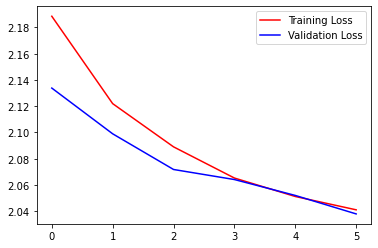

 > Epochs:  12%|█▏        | 6/50 [02:14<16:28, 22.48s/it]

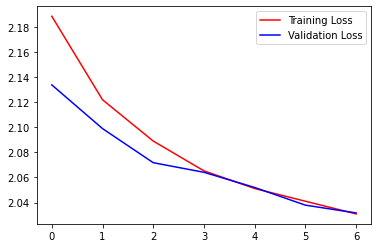

 > Epochs:  14%|█▍        | 7/50 [02:37<16:08, 22.51s/it]

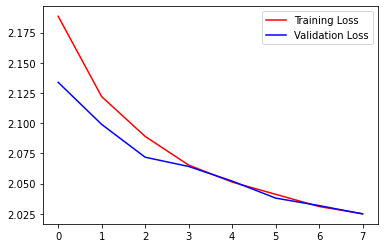

 > Epochs:  16%|█▌        | 8/50 [02:59<15:43, 22.47s/it]

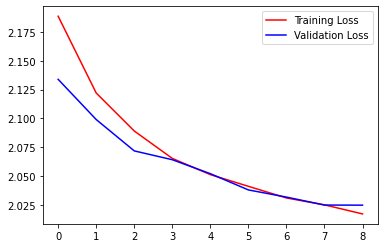

 > Epochs:  18%|█▊        | 9/50 [03:22<15:19, 22.43s/it]

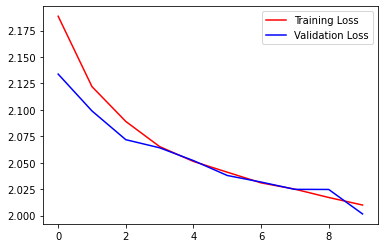

 > Epochs:  20%|██        | 10/50 [03:44<14:55, 22.39s/it]

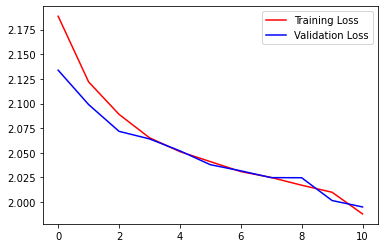

 > Epochs:  22%|██▏       | 11/50 [04:06<14:30, 22.33s/it]

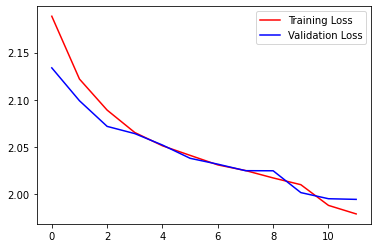

 > Epochs:  24%|██▍       | 12/50 [04:28<14:06, 22.27s/it]

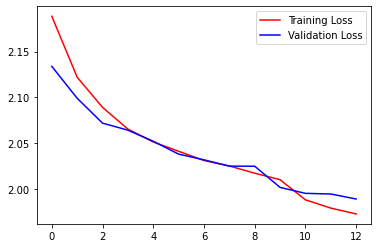

 > Epochs:  26%|██▌       | 13/50 [04:50<13:43, 22.24s/it]

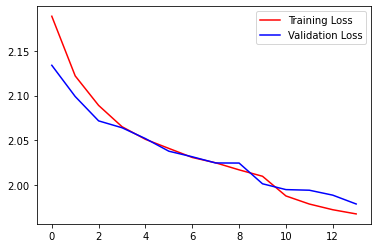

 > Epochs:  28%|██▊       | 14/50 [05:13<13:20, 22.24s/it]

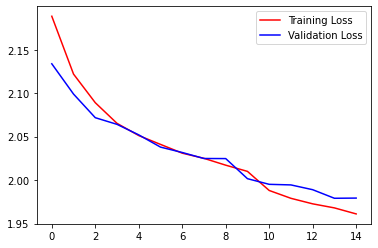

 > Epochs:  30%|███       | 15/50 [05:35<12:57, 22.21s/it]

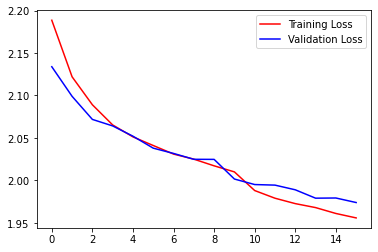

 > Epochs:  32%|███▏      | 16/50 [05:57<12:31, 22.11s/it]

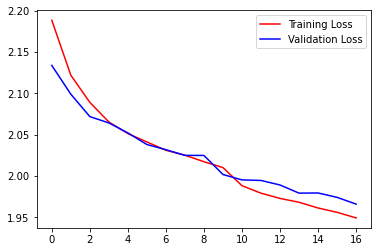

 > Epochs:  34%|███▍      | 17/50 [06:19<12:09, 22.10s/it]

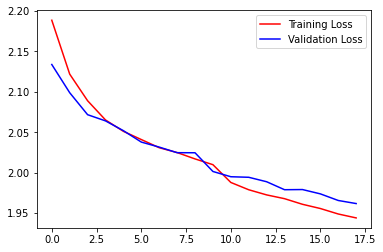

 > Epochs:  36%|███▌      | 18/50 [06:41<11:50, 22.20s/it]

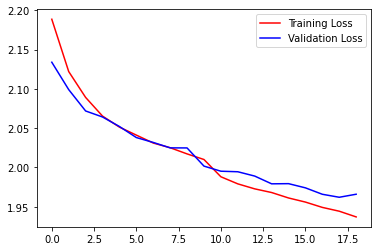

 > Epochs:  38%|███▊      | 19/50 [07:03<11:26, 22.14s/it]

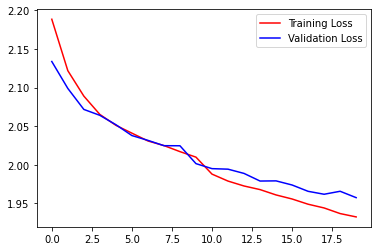

 > Epochs:  40%|████      | 20/50 [07:25<11:04, 22.14s/it]

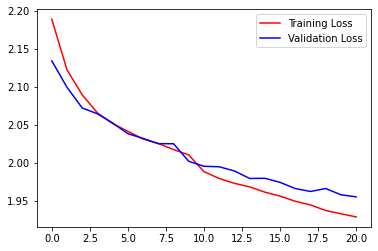

 > Epochs:  42%|████▏     | 21/50 [07:47<10:41, 22.11s/it]

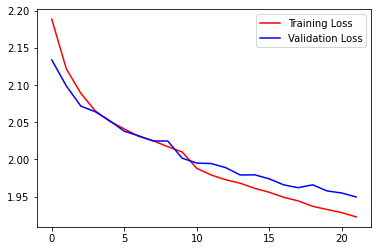

 > Epochs:  44%|████▍     | 22/50 [08:09<10:18, 22.08s/it]

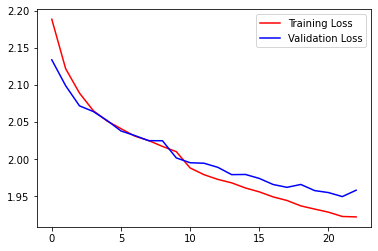

 > Epochs:  46%|████▌     | 23/50 [08:31<09:55, 22.04s/it]

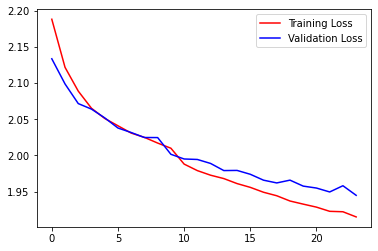

 > Epochs:  48%|████▊     | 24/50 [08:53<09:33, 22.07s/it]

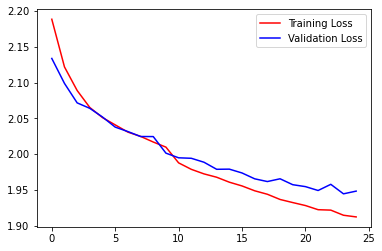

 > Epochs:  50%|█████     | 25/50 [09:18<09:26, 22.66s/it]

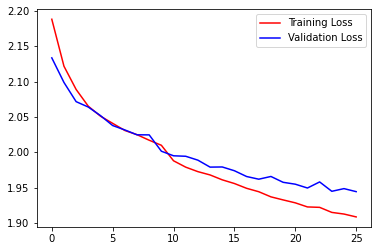

 > Epochs:  52%|█████▏    | 26/50 [09:40<09:01, 22.58s/it]

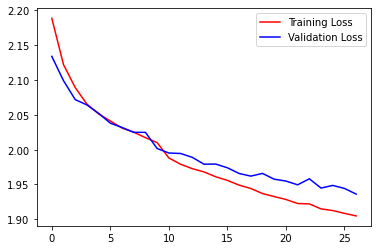

 > Epochs:  54%|█████▍    | 27/50 [10:02<08:37, 22.51s/it]

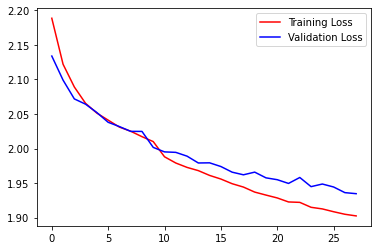

 > Epochs:  56%|█████▌    | 28/50 [10:25<08:14, 22.48s/it]

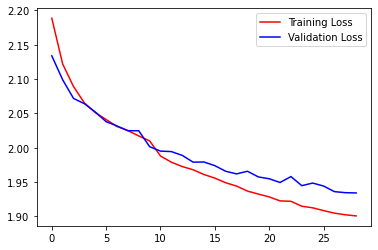

 > Epochs:  58%|█████▊    | 29/50 [10:47<07:52, 22.52s/it]

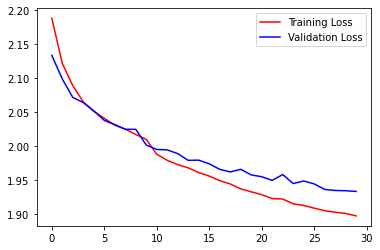

 > Epochs:  60%|██████    | 30/50 [11:10<07:30, 22.54s/it]

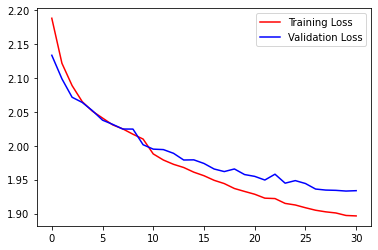

 > Epochs:  62%|██████▏   | 31/50 [11:32<07:07, 22.49s/it]

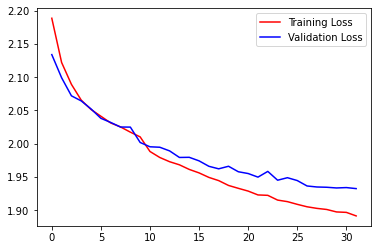

 > Epochs:  64%|██████▍   | 32/50 [11:54<06:42, 22.37s/it]

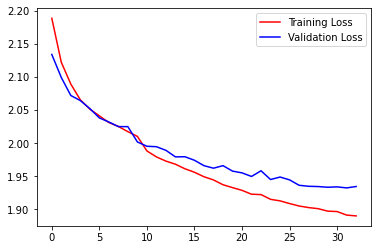

 > Epochs:  66%|██████▌   | 33/50 [12:17<06:19, 22.32s/it]

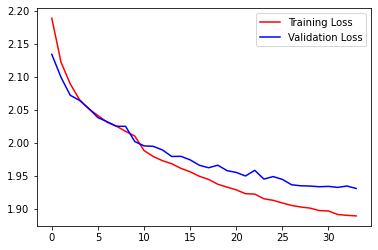

 > Epochs:  68%|██████▊   | 34/50 [12:39<05:57, 22.32s/it]

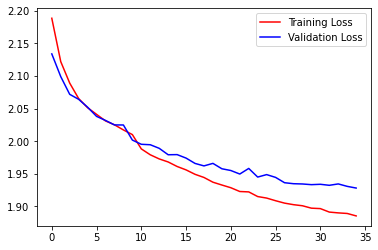

 > Epochs:  70%|███████   | 35/50 [13:01<05:34, 22.33s/it]

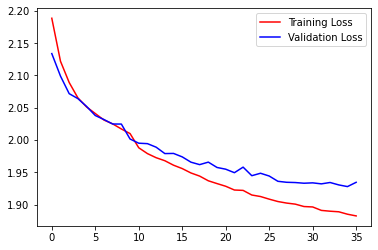

 > Epochs:  72%|███████▏  | 36/50 [13:23<05:12, 22.29s/it]

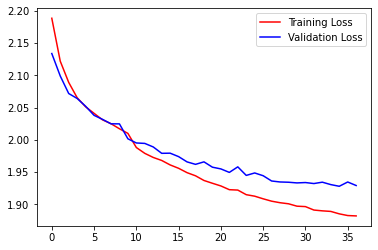

 > Epochs:  74%|███████▍  | 37/50 [13:46<04:49, 22.30s/it]

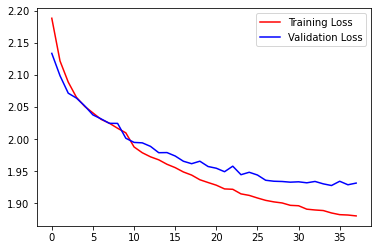

 > Epochs:  76%|███████▌  | 38/50 [14:08<04:28, 22.33s/it]

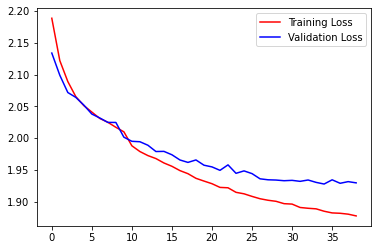

 > Epochs:  78%|███████▊  | 39/50 [14:31<04:06, 22.37s/it]

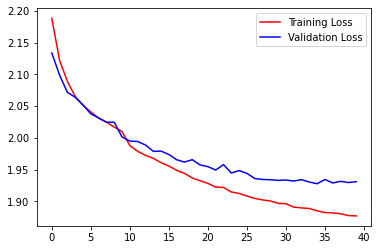

 > Epochs:  80%|████████  | 40/50 [14:53<03:43, 22.30s/it]

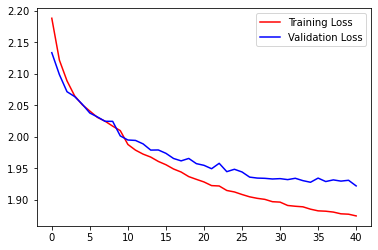

 > Epochs:  82%|████████▏ | 41/50 [15:15<03:20, 22.28s/it]

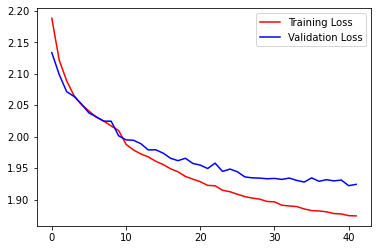

 > Epochs:  84%|████████▍ | 42/50 [15:37<02:57, 22.23s/it]

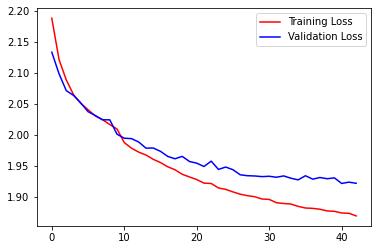

 > Epochs:  86%|████████▌ | 43/50 [15:59<02:35, 22.15s/it]

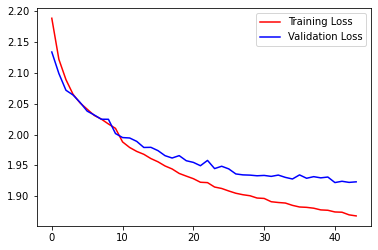

 > Epochs:  88%|████████▊ | 44/50 [16:21<02:13, 22.18s/it]

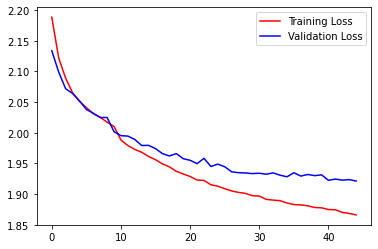

 > Epochs:  90%|█████████ | 45/50 [16:43<01:50, 22.18s/it]

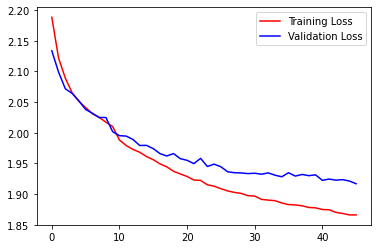

 > Epochs:  92%|█████████▏| 46/50 [17:06<01:28, 22.14s/it]

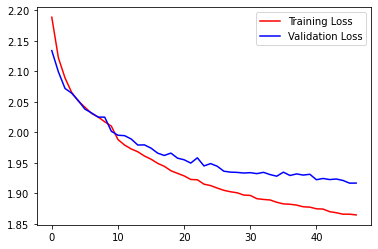

 > Epochs:  94%|█████████▍| 47/50 [17:28<01:06, 22.17s/it]

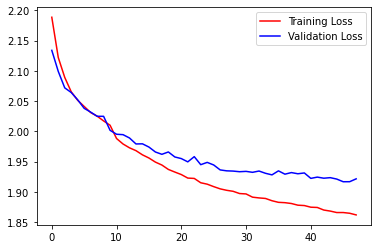

 > Epochs:  96%|█████████▌| 48/50 [17:50<00:44, 22.20s/it]

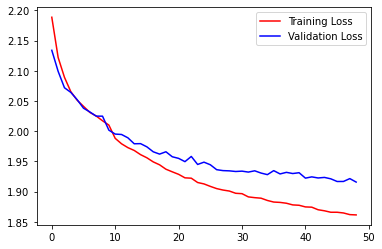

 > Epochs:  98%|█████████▊| 49/50 [18:12<00:22, 22.17s/it]

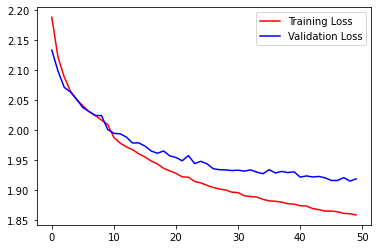

 > Epochs: 100%|██████████| 50/50 [18:34<00:00, 22.30s/it]


In [6]:
# Dataset
dataloader = extract_dataset(BATCH_SIZE)

# Network
network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)

# Loss Function
loss_function = nn.CrossEntropyLoss

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS)

# Inference

 > Input image shape: (32, 32, 3)


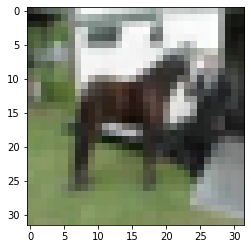



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 7


 > Class Name predicted: horse





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
image = dataloader['valid'].dataset.data[20]

output = nn_model.predict(image)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = dataloader['valid'].dataset.classes[class_index]

print(f' > Classes: {dataloader["valid"].dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')

# Save & Load Model

In [8]:
torch.save(nn_model, 'model_1.pth')

## Entire model

Saving a model in this way will save the entire module using Python’s pickle module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. 

In [ ]:
# Saving
torch.save(network, 'model.pth')

 > Input image shape: (32, 32, 3)


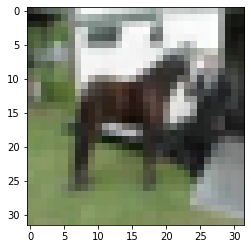



 > Image shape preprocessed: torch.Size([1, 3, 32, 32])

--- Inference ---

 > Output shape: torch.Size([10])
 > Output value: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


 > Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 > Class Index: 7


 > Class Name predicted: horse





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Loading
loaded_network = torch.load('model.pth')

image = valid_dataloader.dataset.data[20]
output = inference(image, loaded_network)
output = output.numpy()

class_index = np.where(output==np.max(output))[0].item()
class_name = valid_dataloader.dataset.classes[class_index]

print(f' > Classes: {valid_dataloader.dataset.classes}')
print(f' > Class Index: {class_index}\n\n')

print(f' > Class Name predicted: {class_name}\n\n\n')

## State Dict

In [ ]:
network_state = network.state_dict()

print(f' > Parameters keys: {network_state.keys()}\n')
print(f' > Example of parameters for a conv_1_weight:\n\nShape: {network_state["conv_1.weight"].shape}\n\nValue: {network_state["conv_1.weight"]}')

 > Parameters keys: odict_keys(['conv_1.weight', 'conv_1.bias', 'conv_2.weight', 'conv_2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

 > Example of parameters for a conv_1_weight:

Shape: torch.Size([4, 3, 5, 5])

Value: tensor([[[[-0.0224,  0.0441, -0.0230, -0.0294,  0.0614],
          [ 0.0146, -0.1116, -0.1284,  0.1000,  0.1623],
          [ 0.0210, -0.0228,  0.1464,  0.0503, -0.1483],
          [-0.0032, -0.0538, -0.0680,  0.0053, -0.1811],
          [-0.1575,  0.1140, -0.0428, -0.0787, -0.0541]],

         [[ 0.0746,  0.0295, -0.0114,  0.0096, -0.0075],
          [ 0.0523,  0.1329,  0.0191, -0.1638, -0.1104],
          [-0.0172, -0.0585,  0.0082, -0.1021, -0.0143],
          [-0.2250,  0.0758, -0.0621, -0.0863,  0.0401],
          [-0.0888,  0.2756, -0.0561,  0.0725, -0.0185]],

         [[ 0.1424, -0.0359,  0.1989, -0.0659,  0.0838],
          [ 0.2261, -0.0163, -0.0203, -0.0467,  0.0373],
          [-0.0921,  0.2276, -0.0823,  0.1258, -0

In [ ]:
torch.save(network.state_dict(), 'model_state')

In [ ]:
# Init Network
network = NeuralNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)

# Load state dict
network.load_state_dict(torch.load('model_state'))

<All keys matched successfully>

## Checkpoint

In [ ]:
# Saving model checkpoint

checkpoint = {
            'epochs': EPOCHS,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }

torch.save(checkpoint, 'model_checkpoint.pth')

In [ ]:
# Loading model checkpoint

network = NeuralNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES)
optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE)

checkpoint = torch.load('model_checkpoint.pth')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epochs']
loss = checkpoint['loss']